# Lab 01 / 02 - Techniques for Handling Large Datasets in Classification; K-means; K-medoids

This homework is an exploration of the first two labs from DZD lessons (mostly the second lab), pertaining to dataset processing, feature engineering, and K-means/K-medoids clustering. We will explore what correlations can be found in the data and how well we can predict them using data clustering on a limited amount of features.

Self-link: https://colab.research.google.com/drive/1sj7PJCsZFktqZGZXOVjZsJZleVTx4d48?usp=sharing

## Data cleanup

We will use the [NYC Yellow Taxi Trip Data](https://www.kaggle.com/datasets/elemento/nyc-yellow-taxi-trip-data) from Kaggle.

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("elemento/nyc-yellow-taxi-trip-data")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'nyc-yellow-taxi-trip-data' dataset.
Path to dataset files: /kaggle/input/nyc-yellow-taxi-trip-data


In [2]:
import pandas as pd

taxi = pd.read_csv(path + "/yellow_tripdata_2015-01.csv")
taxi.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30


In [3]:
import numpy as np
import matplotlib.pyplot as plt

First we will filter away the garbage data. Some indicators of garbage data are:
* Pickup later than dropoff (taxis don't travel in time!)
* Zero distance
* Fare amount below minimum in in NYC
* Passenger count above 12 (most taxis, even large ones, can fit 6 max, I figured I can be generous)
* Pickups and dropoffs way outside of NYC

(I asked my NYC-dwelling friends about some of these.)

In [4]:
print("Raw:", len(taxi))
mask = (
    (taxi["tpep_pickup_datetime"] <= taxi["tpep_dropoff_datetime"]) &
    (taxi["trip_distance"] > 0) &
    (taxi["fare_amount"] >= 2.5) & # min fare in NYC
    (taxi["passenger_count"].between(1, 12)) &
    taxi["pickup_latitude"].between(40.0, 41.5) & # NYC & boroughs & airports
    taxi["pickup_longitude"].between(-75.0, -72.0) &
    taxi["dropoff_latitude"].between(40.0, 41.5) & # NYC & boroughs & airports
    taxi["dropoff_longitude"].between(-75.0, -72.0)
)
clean_taxi = taxi[mask].copy()
print("After removing nonsensical data:", len(clean_taxi))
print("Percentage:", len(clean_taxi)/len(taxi))

Raw: 12748986
After removing nonsensical data: 12424322


We filtered out about 3% of our data. Let's do a few more iterations of this, starting with removing significant outliers.

In [5]:
import gc

In [6]:
del taxi  # free up memory

gc.collect()

0

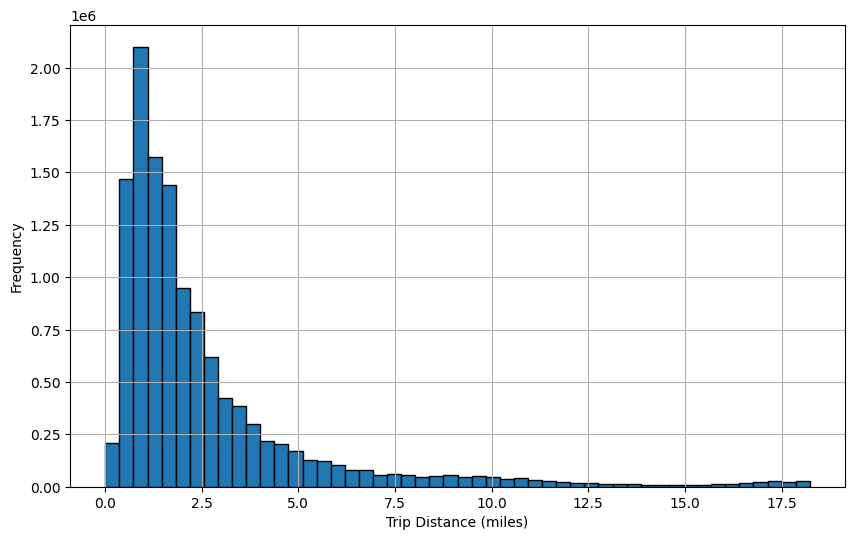

After removing outliers: 12300025


In [7]:
q_high = clean_taxi["trip_distance"].quantile(0.99)
filtered_taxi = clean_taxi[clean_taxi["trip_distance"] < q_high].copy()

plt.figure(figsize=(10, 6))
plt.hist(filtered_taxi["trip_distance"], bins=50, edgecolor='black')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
print(f"After removing outliers: {len(filtered_taxi)}")

In [8]:
print(q_high)

del clean_taxi  # free up memory

gc.collect()

18.24


6134

Check the new coordinates range just to be sure:

In [9]:
print("Latitude range:", filtered_taxi["pickup_latitude"].min(), filtered_taxi["pickup_latitude"].max())
print("Logitude range:", filtered_taxi["dropoff_longitude"].min(), filtered_taxi["dropoff_longitude"].max())

Latitude range: 40.04163360595703 41.49359130859375
Logitude range: -74.8927230834961 -72.44942474365233


In [10]:
filtered_taxi[["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"]].describe()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
count,1.230002e+07,1.230002e+07,1.230002e+07,1.230002e+07
mean,4.075182e+01,-7.397603e+01,4.075208e+01,-7.397469e+01
std,2.564582e-02,3.202561e-02,3.005829e-02,3.151097e-02
min,4.004163e+01,-7.499691e+01,4.003058e+01,-7.489272e+01
25%,4.073764e+01,-7.399194e+01,4.073632e+01,-7.399134e+01
50%,4.075425e+01,-7.398205e+01,4.075446e+01,-7.398025e+01
75%,4.076807e+01,-7.396834e+01,4.076923e+01,-7.396416e+01
max,4.149359e+01,-7.244942e+01,4.141386e+01,-7.244942e+01


In [11]:
filtered_taxi["passenger_count"].value_counts()

,count
passenger_count,
1,8661668
2,1751641
5,683552
3,512219
6,445597
4,245335
7,6
9,4
8,3


Here we confirm that the data overwhelmingly doesn't have rides with passengers above 6. We could filter out the remaining ones.

We will also start engineer new features, starting with converting the datetame into the proper numeric format as well as measuring the total trip duration.

In [12]:
filtered_taxi["dropoff_datetime"] = pd.to_datetime(filtered_taxi["tpep_dropoff_datetime"])
filtered_taxi["pickup_datetime"] = pd.to_datetime(filtered_taxi["tpep_pickup_datetime"])

duration = (filtered_taxi["dropoff_datetime"] - filtered_taxi["pickup_datetime"]).dt.total_seconds() / 60
print(filtered_taxi[duration < 1].size,filtered_taxi[duration > 120].size)

693567 216636


In [13]:
print(len(filtered_taxi[duration < 1]),len(filtered_taxi[duration > 120]))

33027 10316


In [14]:
f2_taxi = filtered_taxi[(duration > 1) & (duration < 120) & filtered_taxi["passenger_count"] <= 6].copy()
duration = (f2_taxi["dropoff_datetime"] - f2_taxi["pickup_datetime"]).dt.total_seconds() / 60 # recompute so that the indices align
print(f"Rows: {len(f2_taxi)}")  # or f2_taxi.shape[0]
print(f"Total elements: {f2_taxi.size}")  # rows × columns

Rows: 12255457
Total elements: 257364597


We're down to 96% of the original dataset.

In [15]:
print(len(f2_taxi))
del filtered_taxi
gc.collect()

12255457


17

In [16]:
f2_taxi.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,...,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,dropoff_datetime,pickup_datetime
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,...,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05,2015-01-15 19:23:42,2015-01-15 19:05:39
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,...,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80,2015-01-10 20:53:28,2015-01-10 20:33:38
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,...,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80,2015-01-10 20:43:41,2015-01-10 20:33:38
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,...,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80,2015-01-10 20:35:31,2015-01-10 20:33:39
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,...,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30,2015-01-10 20:52:58,2015-01-10 20:33:39


## Feature engineering (and more cleanup)

Let's calculate geographical distance of the trip as well (as opposed to the distance on the meter). (Haversine may have been a bit of an overkill, but we figured there's no harm in it.)

In [17]:
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    R = 3959  # Earth radius in miles
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.atan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

In [18]:
f2_taxi["fare_per_mile"] = f2_taxi["fare_amount"] / f2_taxi['trip_distance']
f2_taxi["geo_distance"] = haversine(
    f2_taxi["pickup_latitude"],
    f2_taxi["pickup_longitude"],
    f2_taxi["dropoff_latitude"],
    f2_taxi["dropoff_longitude"]
)
f2_taxi.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,dropoff_datetime,pickup_datetime,fare_per_mile,geo_distance
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,...,1.0,0.5,3.25,0.0,0.3,17.05,2015-01-15 19:23:42,2015-01-15 19:05:39,7.547170,1.001024
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,...,0.5,0.5,2.00,0.0,0.3,17.80,2015-01-10 20:53:28,2015-01-10 20:33:38,4.393939,2.438754
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,...,0.5,0.5,0.00,0.0,0.3,10.80,2015-01-10 20:43:41,2015-01-10 20:33:38,5.277778,1.611153
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,...,0.5,0.5,0.00,0.0,0.3,4.80,2015-01-10 20:35:31,2015-01-10 20:33:39,7.000000,0.493789
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,...,0.5,0.5,0.00,0.0,0.3,16.30,2015-01-10 20:52:58,2015-01-10 20:33:39,5.000000,2.202665


A lot of these features were engineered just to look for any interesting patterns in the displayed dataset subset; we leave them in the final version, but do not include a detailed analysis.

In [19]:
f2_taxi["hour"] = f2_taxi["pickup_datetime"].dt.hour
f2_taxi["day_of_week"] = f2_taxi["pickup_datetime"].dt.dayofweek
f2_taxi["is_weekend"] = f2_taxi["day_of_week"].isin([5, 6])
f2_taxi["is_rush_hour"] = f2_taxi["hour"].between(7, 9) | f2_taxi["hour"].between(16, 18)
f2_taxi["morning_rush"] = f2_taxi["hour"].between(7, 9)
f2_taxi["evening_rush"] = f2_taxi["hour"].between(16, 18)
f2_taxi["speed_mph"] = f2_taxi["trip_distance"] / (duration / 60)
f2_taxi["route_efficiency"] = np.where(
    f2_taxi["geo_distance"] > 0,
    f2_taxi["trip_distance"] / f2_taxi["geo_distance"],
    np.nan
)
f2_taxi.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,...,fare_per_mile,geo_distance,hour,day_of_week,is_weekend,is_rush_hour,morning_rush,evening_rush,speed_mph,route_efficiency
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,...,7.547170,1.001024,19,3,False,False,False,False,5.285319,1.588373
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,...,4.393939,2.438754,20,5,True,False,False,False,9.983193,1.353150
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,...,5.277778,1.611153,20,5,True,False,False,False,10.746269,1.117212
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,...,7.000000,0.493789,20,5,True,False,False,False,16.071429,1.012578
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,...,5.000000,2.202665,20,5,True,False,False,False,9.318378,1.361987


In [20]:
print(len(f2_taxi[f2_taxi['route_efficiency'] > 20]))
f2_taxi[f2_taxi['route_efficiency'] > 20].head()


23109


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,...,fare_per_mile,geo_distance,hour,day_of_week,is_weekend,is_rush_hour,morning_rush,evening_rush,speed_mph,route_efficiency
231,1,2015-01-20 23:08:13,2015-01-20 23:14:04,1,1.20,-74.008102,40.712421,1,N,-74.007866,...,5.416667,0.012399,23,1,False,False,False,False,12.307692,96.785099
799,1,2015-01-10 20:33:36,2015-01-10 20:52:50,1,3.20,-74.002548,40.734013,1,N,-74.004326,...,4.843750,0.135578,20,5,True,False,False,False,9.982669,23.602634
1905,1,2015-01-23 18:09:39,2015-01-23 18:34:52,1,4.00,-73.954872,40.789082,1,N,-73.954262,...,4.500000,0.073463,18,4,False,True,False,True,9.517515,54.449500
2187,2,2015-01-10 21:34:49,2015-01-10 21:57:37,2,2.53,-73.883133,40.744686,1,N,-73.883987,...,5.928854,0.051524,21,5,True,False,False,False,6.657895,49.103319
2337,1,2015-01-10 22:14:50,2015-01-10 22:31:17,1,2.10,-73.984093,40.760674,1,N,-73.984489,...,5.714286,0.023531,22,5,True,False,False,False,7.659574,89.245231


In [21]:
f2_taxi[f2_taxi["trip_distance"] < 0.1]["fare_per_mile"].describe()

,fare_per_mile
count,4305.000000
mean,226.393905
std,765.443901
min,27.777778
25%,50.000000
50%,75.000000
75%,166.666667
max,27500.000000


In [22]:
print((f2_taxi["trip_distance"] > 0.1)[:5], (f2_taxi['route_efficiency'] < 20)[:5])
print(len(f2_taxi["trip_distance"] > 0.1), len(f2_taxi['route_efficiency'] < 20))

0    True
1    True
2    True
3    True
4    True
Name: trip_distance, dtype: bool 0    True
1    True
2    True
3    True
4    True
Name: route_efficiency, dtype: bool
12255457 12255457


Let's filter out a few more anomalies - oddly short trips and oddly geographically inefficient routes (which possible include multiple stops and keeping the taxi driver waiting and thus are harder to analyse):

In [23]:
f3_taxi = f2_taxi[
    (f2_taxi["trip_distance"] > 0.1) &
    (f2_taxi['route_efficiency'] < 20)
]
print(len(f3_taxi))
f3_taxi.head()

12163916


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,...,fare_per_mile,geo_distance,hour,day_of_week,is_weekend,is_rush_hour,morning_rush,evening_rush,speed_mph,route_efficiency
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,...,7.547170,1.001024,19,3,False,False,False,False,5.285319,1.588373
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,...,4.393939,2.438754,20,5,True,False,False,False,9.983193,1.353150
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,...,5.277778,1.611153,20,5,True,False,False,False,10.746269,1.117212
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,...,7.000000,0.493789,20,5,True,False,False,False,16.071429,1.012578
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,...,5.000000,2.202665,20,5,True,False,False,False,9.318378,1.361987


In [24]:
del f2_taxi
gc.collect()

15

This should ensure a high-quality dataset.

Now that we have clean data, we will work with a smaller sample - though large enough for clusters to be of significant size.

In [25]:
taxi_batch = f3_taxi.sample(10000)

## Geographical and time data - unsupervised learning

Let's test the following hypothesis: the traffic usually follows stable geographical patterns. In the morning, people commute to work, to the city center; in the evening the travel home from work, away from the center. This means that geographical data may give us potential information about whether it a part of the morning rush or the evening rush.

Let's engineer the features for it - using the coordinates of the city center as our proxy whether the taxi is heading to or from the business district.

In [26]:
taxi_batch_geo = taxi_batch[["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude", "pickup_datetime", "dropoff_datetime", "is_weekend", "is_rush_hour", "morning_rush", "evening_rush"]].copy()
# Manhattan business district: 40.74-40.76, lon -73.98 to -74.00
taxi_batch_geo["from_business_district"] = taxi_batch_geo["pickup_latitude"].between(40.74, 40.76) & taxi_batch_geo["pickup_longitude"].between(-74.00, -73.98)
taxi_batch_geo["to_business_district"] = taxi_batch_geo["dropoff_latitude"].between(40.74, 40.76) & taxi_batch_geo["dropoff_longitude"].between(-74.00, -73.98)

# dropoff close to midpoint than pickup
midpoint = ((40.75 + 40.74) / 2, (-74.00 + -73.98) / 2)
taxi_batch_geo["headed_downtown"] = np.linalg.norm(taxi_batch_geo[["pickup_latitude", "pickup_longitude"]] - midpoint, axis=1) < np.linalg.norm(taxi_batch_geo[["dropoff_latitude", "dropoff_longitude"]] - midpoint, axis=1)
taxi_batch_geo.head()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,pickup_datetime,dropoff_datetime,is_weekend,is_rush_hour,morning_rush,evening_rush,from_business_district,to_business_district,headed_downtown
3693286,40.750198,-73.979309,40.739681,-73.992004,2015-01-04 15:48:44,2015-01-04 15:54:03,True,False,False,False,False,False,False
7392345,40.798264,-73.936981,40.786423,-73.945618,2015-01-22 02:25:22,2015-01-22 02:27:30,False,False,False,False,False,False,False
9959511,40.712830,-74.013962,40.774311,-73.980560,2015-01-30 17:30:30,2015-01-30 17:55:01,False,True,False,True,False,False,False
3085708,40.743950,-73.999527,40.735180,-74.008499,2015-01-11 20:37:41,2015-01-11 20:41:27,True,False,False,False,True,False,True
9771591,40.762501,-73.985588,40.739239,-73.993752,2015-01-10 18:10:22,2015-01-10 18:19:45,True,True,False,True,False,False,False


We also need to check the clusters are large enough for our analysis to make sense - if they are too small of a share in the dataset, we will likely not be able to find meaningful correlations with the standard k-means.

In [58]:
print("From business district:", taxi_batch_geo["from_business_district"].sum(), "out of", len(taxi_batch_geo))
print("To business district:", taxi_batch_geo["to_business_district"].sum(), "out of", len(taxi_batch_geo))

From business district: 1743 out of 10000
To business district: 1532 out of 10000


10-15% of the dataset is good enough. As for the clusters,

In [71]:
print("Morning rush:", taxi_batch_geo["morning_rush"].sum(), "out of", len(taxi_batch_geo))
print("Evening rush:", taxi_batch_geo["evening_rush"].sum(), "out of", len(taxi_batch_geo))

Morning rush: 1279 out of 10000
Evening rush: 1568 out of 10000


That should give us three uneven, but reasonably sized clusters.

Let's engineer the data and the clusters: we collect the geographical features an try to predict whether a given trip happens during the morning rush hours, evening rush hours, or neither.

In [51]:
taxi_geo_x = taxi_batch_geo[["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude", "is_weekend", "from_business_district", "to_business_district"]]
taxi_geo_x.head()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,is_weekend,from_business_district,to_business_district
3693286,40.750198,-73.979309,40.739681,-73.992004,True,False,False
7392345,40.798264,-73.936981,40.786423,-73.945618,False,False,False
9959511,40.712830,-74.013962,40.774311,-73.980560,False,False,False
3085708,40.743950,-73.999527,40.735180,-74.008499,True,True,False
9771591,40.762501,-73.985588,40.739239,-73.993752,True,False,False


In [34]:
taxi_geo_y = taxi_batch_geo.apply(
    lambda x: 0 if x["morning_rush"] else 1 if x["evening_rush"] else 2,
    axis=1
)
taxi_geo_y.head()

,0
3693286,2
7392345,2
9959511,1
3085708,2
9771591,1


In [36]:
print(np.sum(taxi_geo_y == 0), np.sum(taxi_geo_y == 1), np.sum(taxi_geo_y == 2))

1279 1568 7153


Of course, we should normalize out features before feeding them into the k-means algorithm:

In [52]:
taxi_geo_x_means = taxi_geo_x.mean()
taxi_geo_x_stds = taxi_geo_x.std()
taxi_geo_x_normalized = (taxi_geo_x - taxi_geo_x_means) / taxi_geo_x_stds
taxi_geo_x_normalized.head()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,is_weekend,from_business_district,to_business_district
3693286,-0.055795,-0.107149,-0.409353,-0.556840,1.481786,-0.459426,-0.425321
7392345,1.792512,1.183678,1.140068,0.906069,-0.674794,-0.459426,-0.425321
9959511,-1.492780,-1.163915,0.738581,-0.195925,-0.674794,-0.459426,-0.425321
3085708,-0.296075,-0.723712,-0.558567,-1.077039,1.481786,2.176410,-0.425321
9771591,0.417284,-0.298632,-0.424022,-0.611940,1.481786,-0.459426,-0.425321


In [53]:
taxi_geo_x_normalized.describe()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,is_weekend,from_business_district,to_business_district
count,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04
mean,-6.855601e-14,2.509690e-13,-1.204079e-13,6.897469e-14,6.394885e-18,-4.600764e-17,1.492140e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-6.196427e+00,-1.918216e+00,-6.012330e+00,-6.619733e+00,-6.747938e-01,-4.594263e-01,-4.253214e-01
25%,-5.560110e-01,-4.959907e-01,-5.115898e-01,-5.330798e-01,-6.747938e-01,-4.594263e-01,-4.253214e-01
50%,9.705737e-02,-1.896287e-01,8.747820e-02,-1.740294e-01,-6.747938e-01,-4.594263e-01,-4.253214e-01
75%,6.376137e-01,2.289362e-01,5.585764e-01,3.322142e-01,1.481786e+00,-4.594263e-01,-4.253214e-01
max,6.058580e+00,1.683624e+01,5.169345e+00,1.739556e+01,1.481786e+00,2.176410e+00,2.350928e+00


The K-means implementation is standard:

In [54]:
def k_means(x, n_clusters=3, max_iter=100):
    centers = x.sample(n_clusters).values
    print("Centers:", centers)

    for _ in range(max_iter):
        distances = np.sqrt(((x.values - centers[:, np.newaxis])**2).sum(axis=2))
        #print("Distances:", distances)
        labels = np.argmin(distances, axis=0)
        #print("Labels:", labels)

        new_centers = np.array([x.values[labels == i].mean(axis=0) for i in range(n_clusters)])

        # compute the average between all values

        if np.allclose(centers, new_centers):
            break

        centers = new_centers

    return labels, centers

init_labels, init_centers = k_means(taxi_geo_x_normalized, n_clusters=3, max_iter=1)
print("Initial cluster sizes:", np.sum(init_labels == 0), np.sum(init_labels == 1), np.sum(init_labels == 2))
print("Initial average distance:", np.mean(np.sqrt(((taxi_geo_x_normalized.values - init_centers[:, np.newaxis])**2).sum(axis=2))))

labels, centers = k_means(taxi_geo_x_normalized, n_clusters=3)
print("Cluster sizes:", np.sum(labels == 0), np.sum(labels == 1), np.sum(labels == 2))
print("average distance:", np.mean(np.sqrt(((taxi_geo_x_normalized.values - centers[:, np.newaxis])**2).sum(axis=2))))

Centers: [[ 0.58187112 -0.63367042 -1.53971069 -1.06163996 -0.67479381 -0.45942628
  -0.42532141]
 [ 0.80865541  0.46683642  0.47783661  0.43447345 -0.67479381 -0.45942628
  -0.42532141]
 [ 0.43077939 -0.30421637  0.5415686  -0.58114165 -0.67479381 -0.45942628
  -0.42532141]]
Initial cluster sizes: 1890 3588 4522
Initial average distance: 2.6997905675260463
Centers: [[ 0.74895217  0.78884519  0.82343089  0.88200818 -0.67479381 -0.45942628
  -0.42532141]
 [-0.36619281 -0.74697842 -0.44931205 -0.57632945  1.48178596 -0.45942628
  -0.42532141]
 [ 0.81643003  0.90238586  0.15285406  0.22369903 -0.67479381 -0.45942628
  -0.42532141]]
Cluster sizes: 3370 2777 3853
average distance: 2.725782246857326


Let's measure the performance. With three clusters and unsupervised learning, we have to either draw confusion matrices or measure efficiency in some other way. The two classical measures are similarity between clusters (Rand index, from 0 to 1) or dependence (NMI, from -1 to 1).

In [55]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari = adjusted_rand_score(taxi_geo_y, labels)
nmi = normalized_mutual_info_score(taxi_geo_y, labels)

print("Adjusted Rand Index (ARI):", ari)
print("Normalized Mutual Information (NMI):", nmi)

Adjusted Rand Index (ARI): -0.0026176456894256694
Normalized Mutual Information (NMI): 0.006052552396797537


This is a pretty poor result. May a more sophisticated algrothim perform better?

In [46]:
import umap

In [72]:
import numpy as np
import pandas as pd

def k_medoids(x, n_clusters=2, max_iter=100):
    x_np = x.values if isinstance(x, pd.DataFrame) else x

    medoid_indices = np.random.choice(len(x_np), n_clusters, replace=False)
    medoids = x_np[medoid_indices]

    for iteration in range(max_iter):
        # x_np: (n_samples, n_features)
        # medoids: (n_clusters, n_features)
        # distance: (n_samples, n_clusters)
        distances = np.sqrt(((x_np[:, np.newaxis, :] - medoids[np.newaxis, :, :])**2).sum(axis=2))

        # choose closest
        labels = np.argmin(distances, axis=1)

        # find new medoids
        new_medoids = np.empty_like(medoids)
        for i in range(n_clusters):
            cluster_points = x_np[labels == i]
            if len(cluster_points) == 0:
                # If a cluster becomes empty, keep the old medoid or reinitialize it randomly
                # This can happen if a medoid is an outlier
                new_medoids[i] = medoids[i]
                continue

            min_cost = np.inf
            best_medoid_candidate = None

            for p_candidate in cluster_points:
                # Calculate distances from p_candidate to all other points in the cluster
                cost = np.sum(np.sqrt(((cluster_points - p_candidate)**2).sum(axis=1)))
                if cost < min_cost:
                    min_cost = cost
                    best_medoid_candidate = p_candidate
            new_medoids[i] = best_medoid_candidate

        # convergence Check
        if np.allclose(medoids, new_medoids):
            print(f"K-Medoids converged after {iteration + 1} iterations.")
            break
        medoids = new_medoids

    final_distances = np.sqrt(((x_np[:, np.newaxis, :] - medoids[np.newaxis, :, :])**2).sum(axis=2))
    final_labels = np.argmin(final_distances, axis=1)

    return final_labels, medoids

print("Initial run with:")
init_labels_medoids, init_medoids = k_medoids(taxi_geo_x_normalized, n_clusters=3, max_iter=1)
print("Initial Medoids:\n", init_medoids)
print(f"Cluster 0 size: {np.sum(init_labels_medoids == 0)}, Cluster 1 size: {np.sum(init_labels_medoids == 1)}, Cluster 2 size: {np.sum(init_labels_medoids == 2)}")

init_distances_to_medoids = np.min(np.sqrt(((taxi_geo_x_normalized.values[:, np.newaxis, :] - init_medoids[np.newaxis, :, :])**2).sum(axis=2)), axis=1)
print("Average distance to medoids (initial state):", np.mean(init_distances_to_medoids))

print("\nRunning K-Medoids for full convergence:")
labels_medoids, medoids = k_medoids(taxi_geo_x_normalized, n_clusters=3)
print("Final Medoids:\n", medoids)
print(f"Cluster 0 size: {np.sum(labels_medoids == 0)}, Cluster 1 size: {np.sum(labels_medoids == 1)}, Cluster 2 size: {np.sum(labels_medoids == 2)}")

final_distances_to_medoids = np.min(np.sqrt(((taxi_geo_x_normalized.values[:, np.newaxis, :] - medoids[np.newaxis, :, :])**2).sum(axis=2)), axis=1)
print("Average distance to medoids (final state):", np.mean(final_distances_to_medoids))

Initial run with:
Initial Medoids:
 [[ 0.03838097 -0.09993624 -0.06717303 -0.53903489 -0.67479381 -0.45942628
   2.35092799]
 [-0.58490909 -0.57341011 -0.63216215 -0.38384139 -0.67479381 -0.45942628
  -0.42532141]
 [ 0.72328125  0.28419417  0.74806529  0.35242542 -0.67479381 -0.45942628
  -0.42532141]]
Cluster 0 size: 1532, Cluster 1 size: 4037, Cluster 2 size: 4431
Average distance to medoids (initial state): 1.9682897901902117

Running K-Medoids for full convergence:
K-Medoids converged after 7 iterations.
Final Medoids:
 [[-0.07207736 -0.38006525  0.01299776 -0.14780292 -0.67479381  2.1764101
  -0.42532141]
 [ 0.78562492  0.32142061  0.48327406  0.2994912  -0.67479381 -0.45942628
  -0.42532141]
 [-0.74201516 -0.47289871 -0.67958178 -0.46444577 -0.67479381 -0.45942628
  -0.42532141]]
Cluster 0 size: 1743, Cluster 1 size: 4632, Cluster 2 size: 3625
Average distance to medoids (final state): 1.9523060467468178


In [57]:
ari_medoids = adjusted_rand_score(taxi_geo_y, labels_medoids)
nmi_medoids = normalized_mutual_info_score(taxi_geo_y, labels_medoids)

print("Adjusted Rand Index (ARI):", ari)
print("Normalized Mutual Information (NMI):", nmi)

Adjusted Rand Index (ARI): -0.0026176456894256694
Normalized Mutual Information (NMI): 0.006052552396797537


Not much better. Let's visualize our clusters to see if there are any significant abnormalities.

## Results analysis

In [48]:
import umap

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


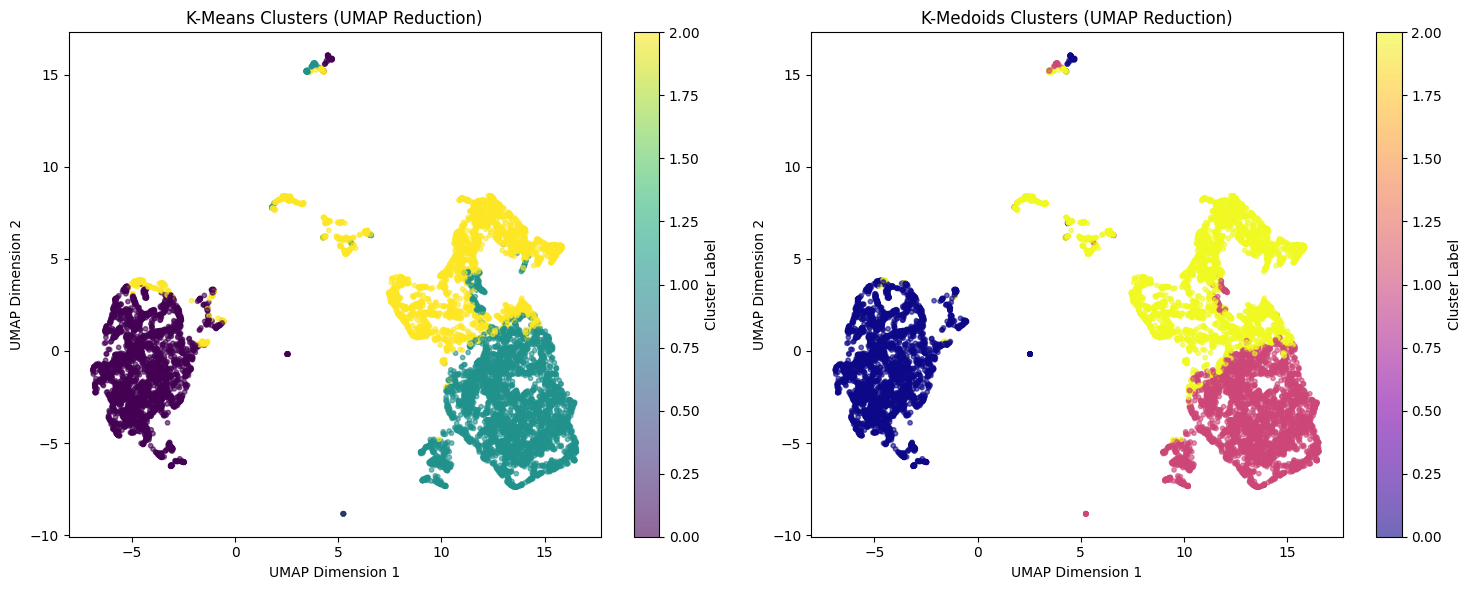

In [49]:
reducer = umap.UMAP(n_components=2, random_state=42)
embedding_k_means = reducer.fit_transform(taxi_geo_x_normalized)
embedding_k_medoids = reducer.fit_transform(taxi_geo_x_normalized)

plt.figure(figsize=(15, 6))

# K-Means visualization
plt.subplot(1, 2, 1)
plt.scatter(embedding_k_means[:, 0], embedding_k_means[:, 1], c=labels, cmap='viridis', s=10, alpha=0.6)
plt.title('K-Means Clusters (UMAP Reduction)')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.colorbar(label='Cluster Label')

# K-Medoids visualization
plt.subplot(1, 2, 2)
plt.scatter(embedding_k_medoids[:, 0], embedding_k_medoids[:, 1], c=labels_medoids, cmap='plasma', s=10, alpha=0.6)
plt.title('K-Medoids Clusters (UMAP Reduction)')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.colorbar(label='Cluster Label')

plt.tight_layout()
plt.show()

Despite nicely-looking clusters, the ARI and NMI results are poor. Let's visualize our data to figure out why. The end clusters are very similar to each other according to ARI, so perhaps our geographical data just predicts our time data poorly?

In [59]:
print(pd.crosstab(taxi_batch_geo["to_business_district"], taxi_geo_y))
print(pd.crosstab(taxi_batch_geo["from_business_district"], taxi_geo_y))

col_0                    0     1     2
to_business_district                  
False                 1053  1309  6106
True                   226   259  1047
col_0                      0     1     2
from_business_district                  
False                   1063  1309  5885
True                     216   259  1268


This confirms it, but let's calculate the percentage and visualize the geographical data:

In [61]:
morning_trips = taxi_batch_geo[(taxi_batch_geo["morning_rush"]) & (~taxi_batch_geo["is_weekend"])]
evening_trips = taxi_batch_geo[(taxi_batch_geo["evening_rush"]) & (~taxi_batch_geo["is_weekend"])]

print(f"Morning rush trips (weekday 7-9 AM): {len(morning_trips)}")
print(f"Evening rush trips (weekday 4-6 PM): {len(evening_trips)}")

print("\n--- Business District Flow ---")
print(f"Morning: TO business district: {morning_trips['to_business_district'].mean():.1%}, FROM: {morning_trips['from_business_district'].mean():.1%}")
print(f"Evening: TO business district: {evening_trips['to_business_district'].mean():.1%}, FROM: {evening_trips['from_business_district'].mean():.1%}")

print(f"\nMorning headed downtown: {morning_trips['headed_downtown'].mean():.1%}")
print(f"Evening headed downtown: {evening_trips['headed_downtown'].mean():.1%}")

Morning rush trips (weekday 7-9 AM): 1031
Evening rush trips (weekday 4-6 PM): 1092

--- Business District Flow ---
Morning: TO business district: 17.0%, FROM: 17.1%
Evening: TO business district: 16.7%, FROM: 17.5%

Morning headed downtown: 45.3%
Evening headed downtown: 51.6%


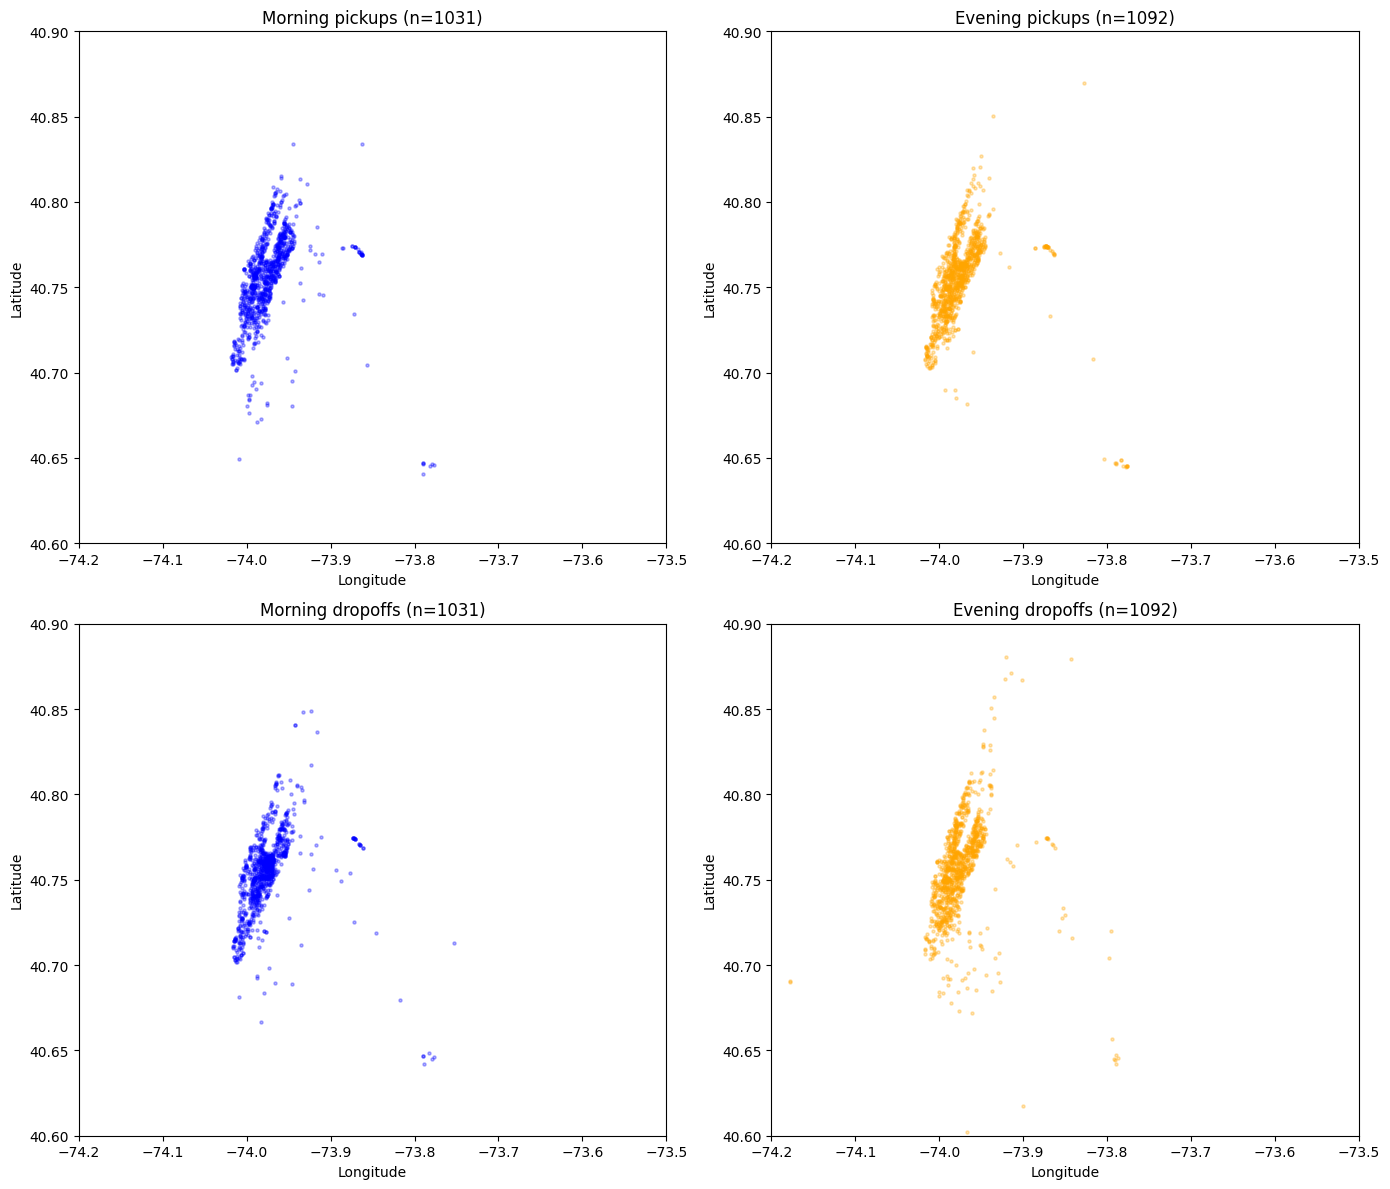

In [66]:
# morning vs evening
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

def set_labels(ax):
  ax.set_xlim(-74.20, -73.5)
  ax.set_ylim(40.6, 40.9)
  ax.set_xlabel('Longitude')
  ax.set_ylabel('Latitude')

# Morning pickups
axes[0, 0].scatter(morning_trips["pickup_longitude"], morning_trips["pickup_latitude"],
                   alpha=0.3, s=5, c='blue')
axes[0, 0].set_title(f'Morning pickups (n={len(morning_trips)})')
set_labels(axes[0,0])

# Evening pickups
axes[0, 1].scatter(evening_trips["pickup_longitude"], evening_trips["pickup_latitude"],
                   alpha=0.3, s=5, c='orange')
axes[0, 1].set_title(f'Evening pickups (n={len(evening_trips)})')
set_labels(axes[0,1])

# Morning dropoffs
axes[1, 0].scatter(morning_trips["dropoff_longitude"], morning_trips["dropoff_latitude"],
                   alpha=0.3, s=5, c='blue')
axes[1, 0].set_title(f'Morning dropoffs (n={len(morning_trips)})')
set_labels(axes[1,0])

# Evening dropoffs
axes[1, 1].scatter(evening_trips["dropoff_longitude"], evening_trips["dropoff_latitude"],
                   alpha=0.3, s=5, c='orange')
axes[1, 1].set_title(f'Evening dropoffs (n={len(evening_trips)})')
set_labels(axes[1,1])

plt.tight_layout()
plt.show()

Likely conclusion" daily commuters don't use taxis, and tourists don't care much for the business districts.

## More hypotheses for the dataset


Let's try exploring more to find whether there is anything we can predict more reliably from the data. How about airport trips?

In [70]:
# Airport zones
jfk = (40.64, -73.78)
lga = (40.77, -73.87)

taxi_batch["near_jfk"] = ((taxi_batch["pickup_latitude"] - 40.64).abs() < 0.03) | \
                          ((taxi_batch["dropoff_latitude"] - 40.64).abs() < 0.03)

In [67]:
taxi_batch["near_jfk"] = (
    (taxi_batch["pickup_latitude"].between(40.62, 40.66) & taxi_batch["pickup_longitude"].between(-73.82, -73.76)) |
    (taxi_batch["dropoff_latitude"].between(40.62, 40.66) & taxi_batch["dropoff_longitude"].between(-73.82, -73.76))
)
taxi_batch["near_lga"] = (
    (taxi_batch["pickup_latitude"].between(40.76, 40.78) & taxi_batch["pickup_longitude"].between(-73.89, -73.85)) |
    (taxi_batch["dropoff_latitude"].between(40.76, 40.78) & taxi_batch["dropoff_longitude"].between(-73.89, -73.85))
)
taxi_batch["airport_trip"] = taxi_batch["near_jfk"] | taxi_batch["near_lga"]

airport = taxi_batch[taxi_batch["airport_trip"]]
local = taxi_batch[~taxi_batch["airport_trip"]]

print(f"Airport trips: {len(airport)}, Local trips: {len(local)}")
print(f"Airport avg fare: ${airport['fare_amount'].mean():.2f}, distance: {airport['trip_distance'].mean():.1f} mi")
print(f"Local avg fare: ${local['fare_amount'].mean():.2f}, distance: {local['trip_distance'].mean():.1f} mi")


Airport trips: 481, Local trips: 9519
Airport avg fare: $34.44, distance: 11.2 mi
Local avg fare: $10.33, distance: 2.2 mi


Looks like airport trips are more expensive, but perhaps there aren't enough of them for k-means to perform realiable. What about nighttime/daytime pickups - would they have more significant differences than the rush hour trips (entertainment districts etc?)

Late night (1-4 AM): 788, Daytime (10 AM-4 PM): 3348


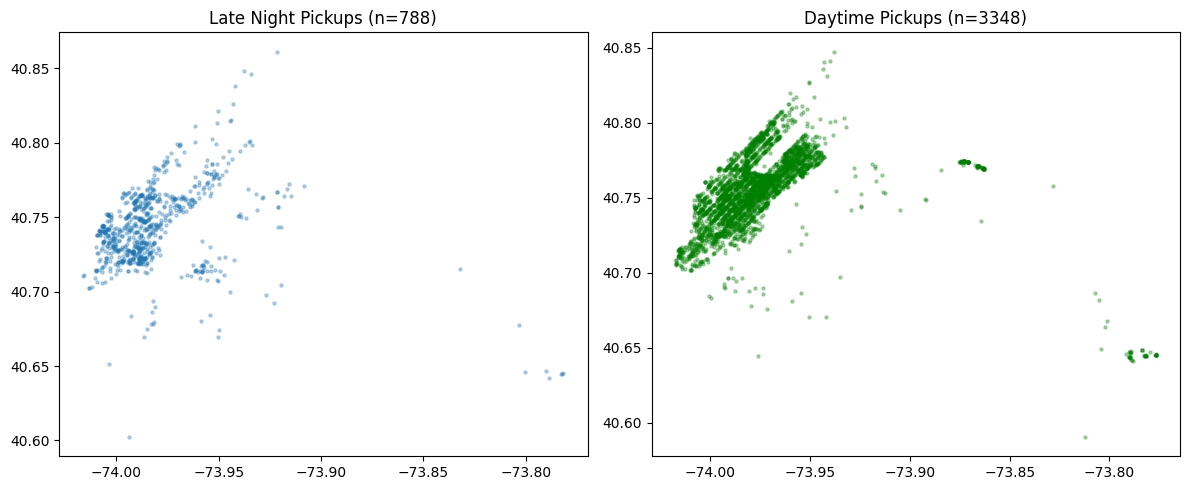

In [68]:
late_night = taxi_batch[taxi_batch["hour"].between(1, 4)]
daytime = taxi_batch[taxi_batch["hour"].between(10, 16)]

print(f"Late night (1-4 AM): {len(late_night)}, Daytime (10 AM-4 PM): {len(daytime)}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(late_night["pickup_longitude"], late_night["pickup_latitude"], alpha=0.3, s=5)
axes[0].set_title(f'Late Night Pickups (n={len(late_night)})')
axes[1].scatter(daytime["pickup_longitude"], daytime["pickup_latitude"], alpha=0.3, s=5, c='green')
axes[1].set_title(f'Daytime Pickups (n={len(daytime)})')
plt.tight_layout()
plt.show()


# Unsupervised exploration

If we cluster by coordinates only using our k-means, can we spot anything interesting in the data?

(The following code was re-run several times with different cluster size. We only leave N=3 clusters version as the most productive one.)

In [80]:
# Cluster only by coordinates
N_CLUSTERS = 3
geo_only = taxi_batch[["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"]]
geo_normalized = (geo_only - geo_only.mean()) / geo_only.std()

geo_labels, geo_centers = k_means(geo_normalized, n_clusters=N_CLUSTERS)

print("--- What characterizes each geographic cluster? ---\n")
for c in range(N_CLUSTERS):
    subset = taxi_batch[geo_labels == c]
    print(f"Cluster {c} (n={len(subset)}):")
    print(f"  Avg fare: ${subset['fare_amount'].mean():.2f}")
    print(f"  Avg distance: {subset['trip_distance'].mean():.1f} mi")
    print(f"  Avg tip %: {(subset['tip_amount']/subset['total_amount']).mean()*100:.1f}%")
    print(f"  Weekend %: {subset['is_weekend'].mean()*100:.1f}%")
    print(f"  Rush hour %: {subset['is_rush_hour'].mean()*100:.1f}%")
    print(f"  Avg hour: {subset['hour'].mean():.1f}")
    print()


Centers: [[-0.55307715 -0.78397221  0.65145569  0.47802387]
 [-0.25104038 -0.04176991  1.13336561  0.71334052]
 [ 1.01490296  0.83002695  0.18332908  1.81365037]]
--- What characterizes each geographic cluster? ---

Cluster 0 (n=5209):
  Avg fare: $10.49
  Avg distance: 2.3 mi
  Avg tip %: 10.0%
  Weekend %: 33.2%
  Rush hour %: 26.3%
  Avg hour: 13.5

Cluster 1 (n=4550):
  Avg fare: $11.18
  Avg distance: 2.6 mi
  Avg tip %: 9.0%
  Weekend %: 29.1%
  Rush hour %: 31.1%
  Avg hour: 13.5

Cluster 2 (n=241):
  Avg fare: $38.94
  Avg distance: 12.4 mi
  Avg tip %: 8.5%
  Weekend %: 30.7%
  Rush hour %: 24.1%
  Avg hour: 13.2



There are significant price differences! What to they correspond to geographically?

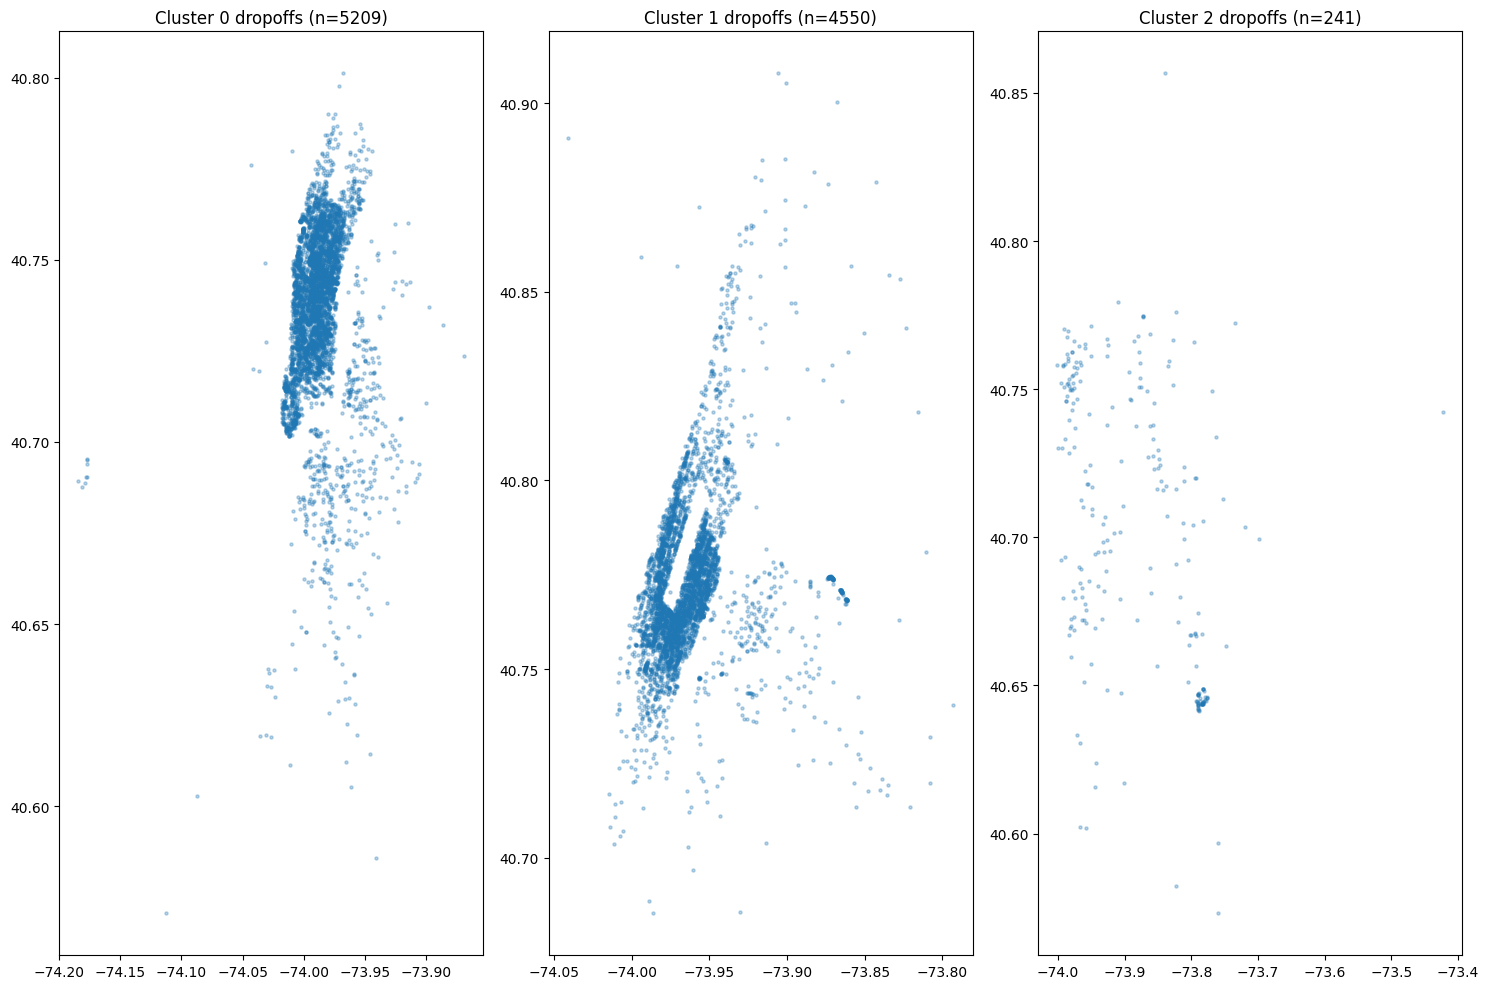

In [92]:
fig, axes = plt.subplots(int(np.ceil(N_CLUSTERS//3)), 3, figsize=(15, 10))
for c in range(N_CLUSTERS):
    if len(axes.shape) == 1:
        ax = axes[c]
    else:
        ax = axes[c // 3, c % 3]
    subset = taxi_batch[geo_labels == c]
    ax.scatter(subset["dropoff_longitude"], subset["dropoff_latitude"], alpha=0.3, s=5)
    ax.set_title(f'Cluster {c} dropoffs (n={len(subset)})')
plt.tight_layout()
plt.show()


There clusters correspond to:

- Upper/Mid Manhatta
- Lower Manhattan + Brooklyn + the JFK
- Outliers

So the k-means can still find some real geographical tendencies.

## Conclusions

* A much smaller sample, when cleaned up and sampled representatively, is enough to find correlations in the data.
* Business districts traffic is nearly identical depending on the time of the day, most likely because taxi data is different from the public transport data.
* However, geographical clustering nevertheless shows interesting correlations regarding fair amount, tip percentage etc.
* Normalization is essential for k-means algorithm to function well.
* Cluster count matters - the data is significantly noisier if the initial count is poorly chosen.